Copied and modified from https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as stats

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.1


---

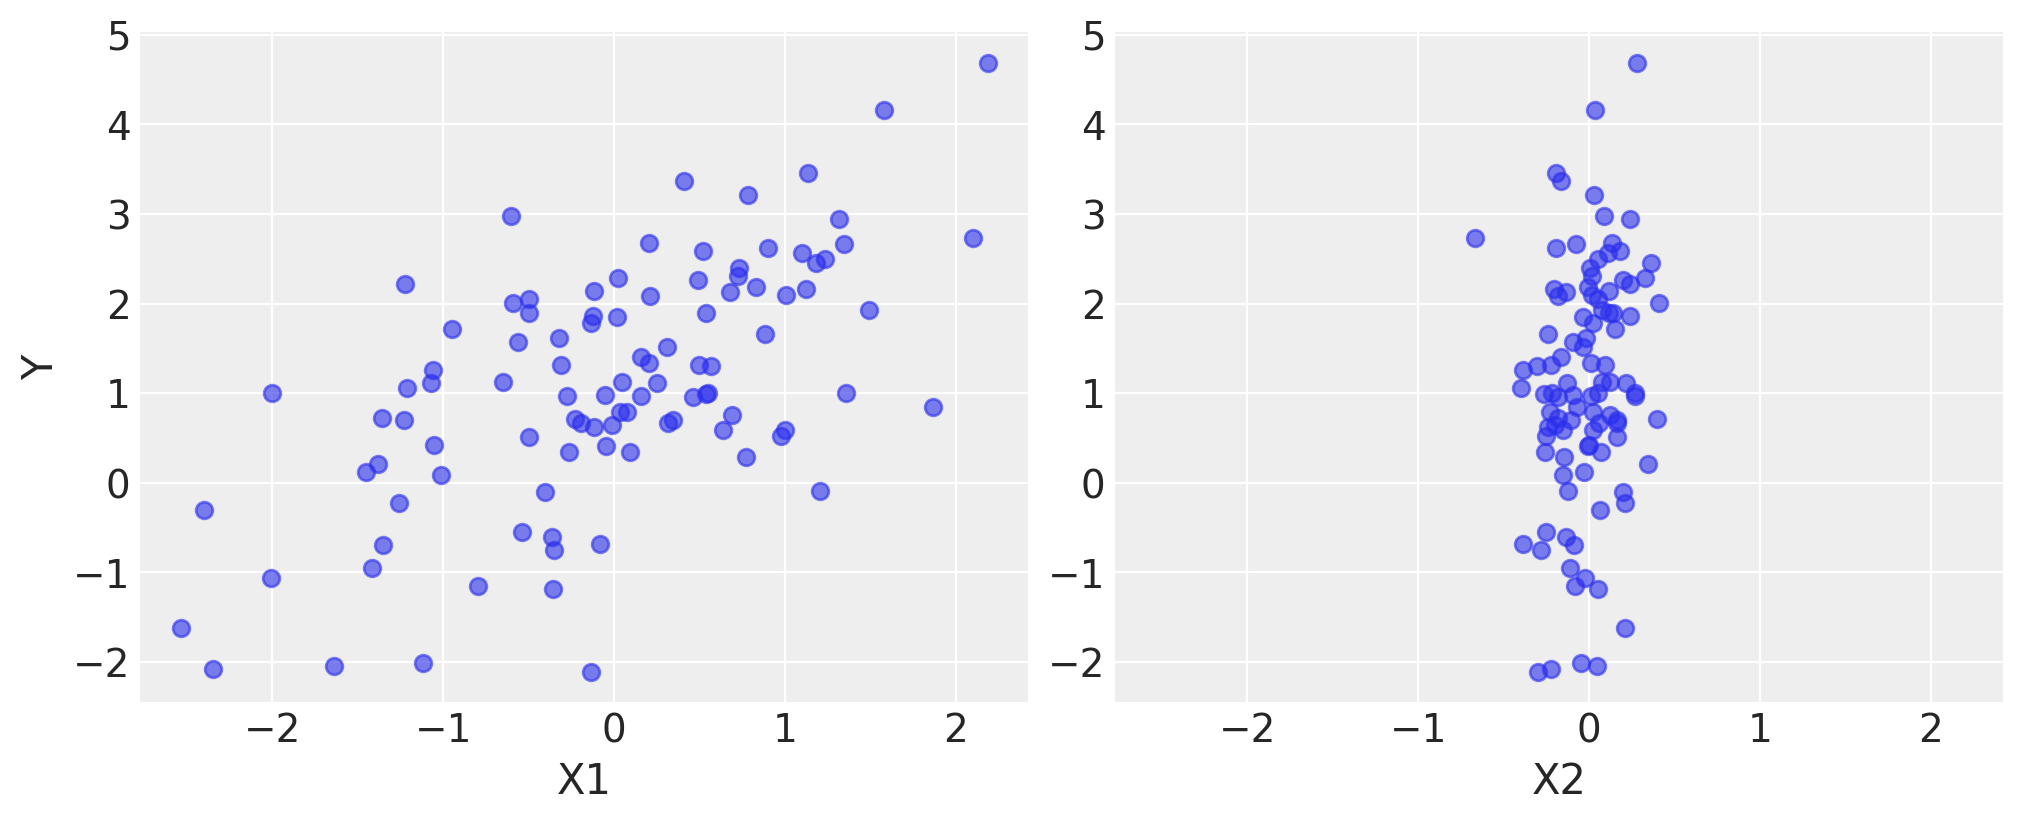

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [4]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

`with basic_model:`

> This creates a context manager, with our basic_model as the context, that includes all statements until the indented block ends. This means all PyMC objects introduced in the indented code block below the with statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with basic_model right after we create them. If you try to create a new random variable without a with model: statement, it will raise an error since there is no obvious model for the variable to be added to.

```
alpha = pm.Normal("alpha", mu=0, sigma=10)
beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
sigma = pm.HalfNormal("sigma", sigma=1)
```

> create **stochastic** random variables with normally-distributed prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10, and a half-normal distribution for the standard deviation of the observations, `σ`. These are stochastic because their values are partly determined by their parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic).

> The beta variable has an additional shape argument to denote it as a vector-valued parameter of size 2. 

> We choose a half-normal distribution (normal distribution bounded at zero) as the prior for `σ`.

Sigma can only be positive e.g. half normal

`mu = alpha + beta[0]*X1 + beta[1]*X2`

> This creates a **deterministic** random variable, which implies that its value is completely determined by its parents’ values. That is, there is no uncertainty beyond that which is inherent in the parents’ values.

```
Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
```

`Y_obs`

> the sampling distribution of the outcomes in the dataset.

> This is a special case of a stochastic variable that we call an observed stochastic, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its observed argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a ndarray or DataFrame object.

> Notice that, unlike for the priors of the model, the **parameters** for the normal distribution of Y_obs are **not fixed values**, but rather are the **deterministic object** `mu` and the **stochastic** `sigma`. This creates parent-child relationships between the likelihood and these two variables.

In [5]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

> The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns an InferenceData object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data. Notice that sample generated a set of parallel chains, depending on how many compute cores are on your machine.

> we can retrieve the sampling trace from the alpha latent variable by using the variable name as an index to the idata.posterior attribute.

In [12]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 1000)>
array([[1.23466423, 1.33110402, 1.03061853, ..., 1.16300951, 1.05211027,
        1.2153419 ],
       [1.18651514, 1.13939388, 1.17834183, ..., 1.15480542, 1.28708283,
        1.43494654],
       [1.30667685, 1.08763621, 0.99028498, ..., 1.27500806, 1.0365473 ,
        1.25723782],
       [0.98266784, 1.41593189, 1.25901293, ..., 1.20792352, 1.23202958,
        1.18866248]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [19]:
idata.posterior["alpha"].data.shape

(4, 1000)

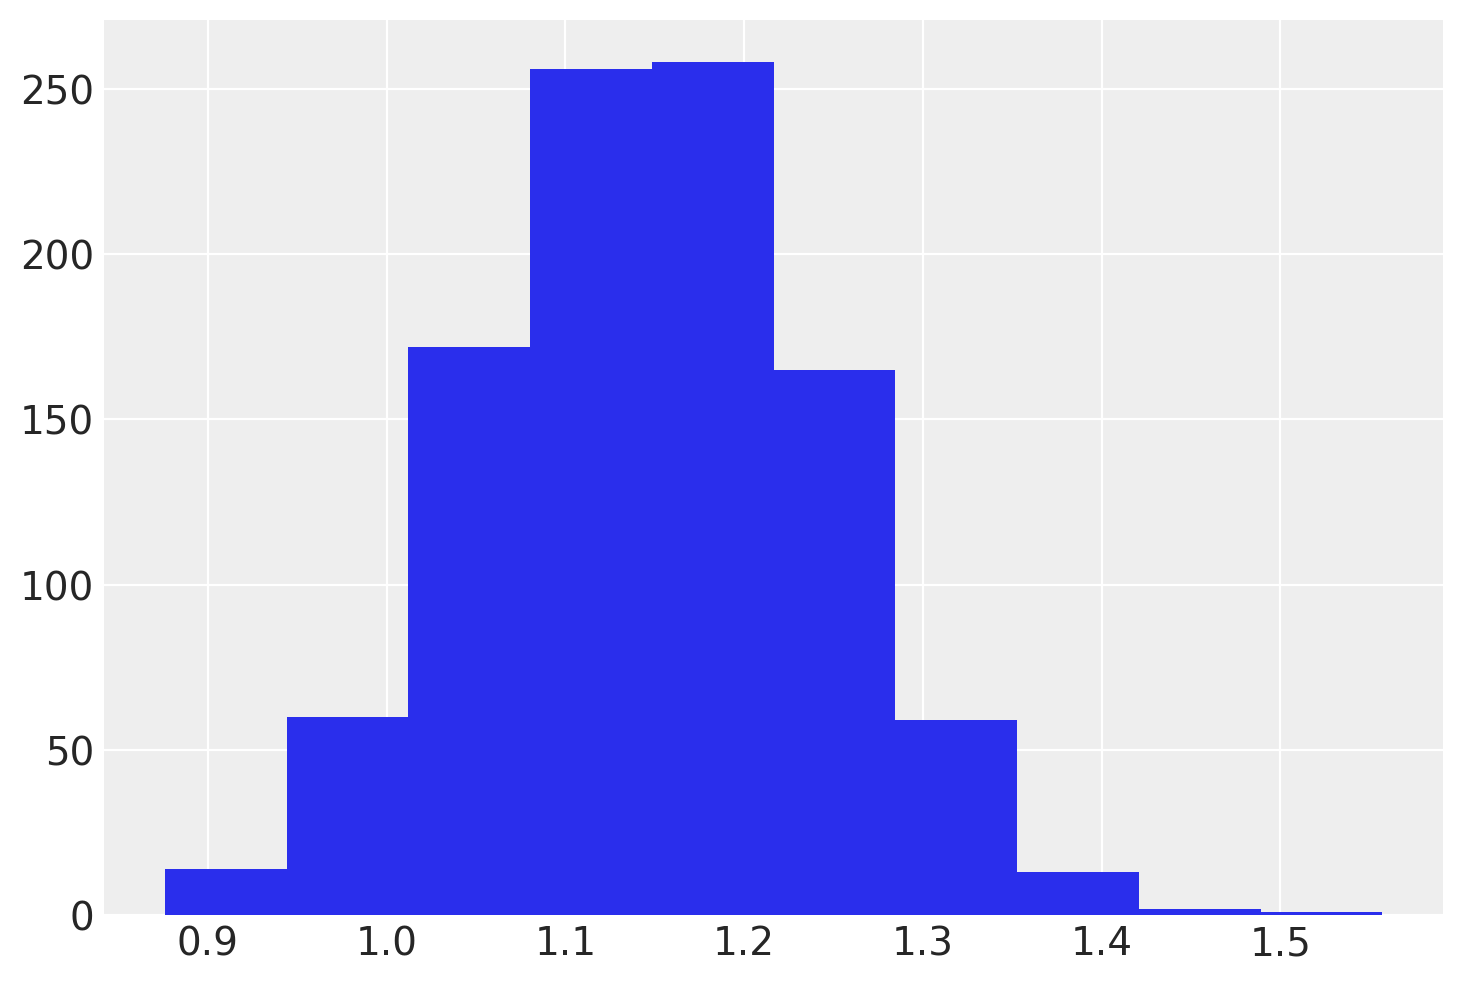

In [25]:
# alpha samples from last chain
plt.hist(idata.posterior["alpha"].data[3, :])
plt.show()

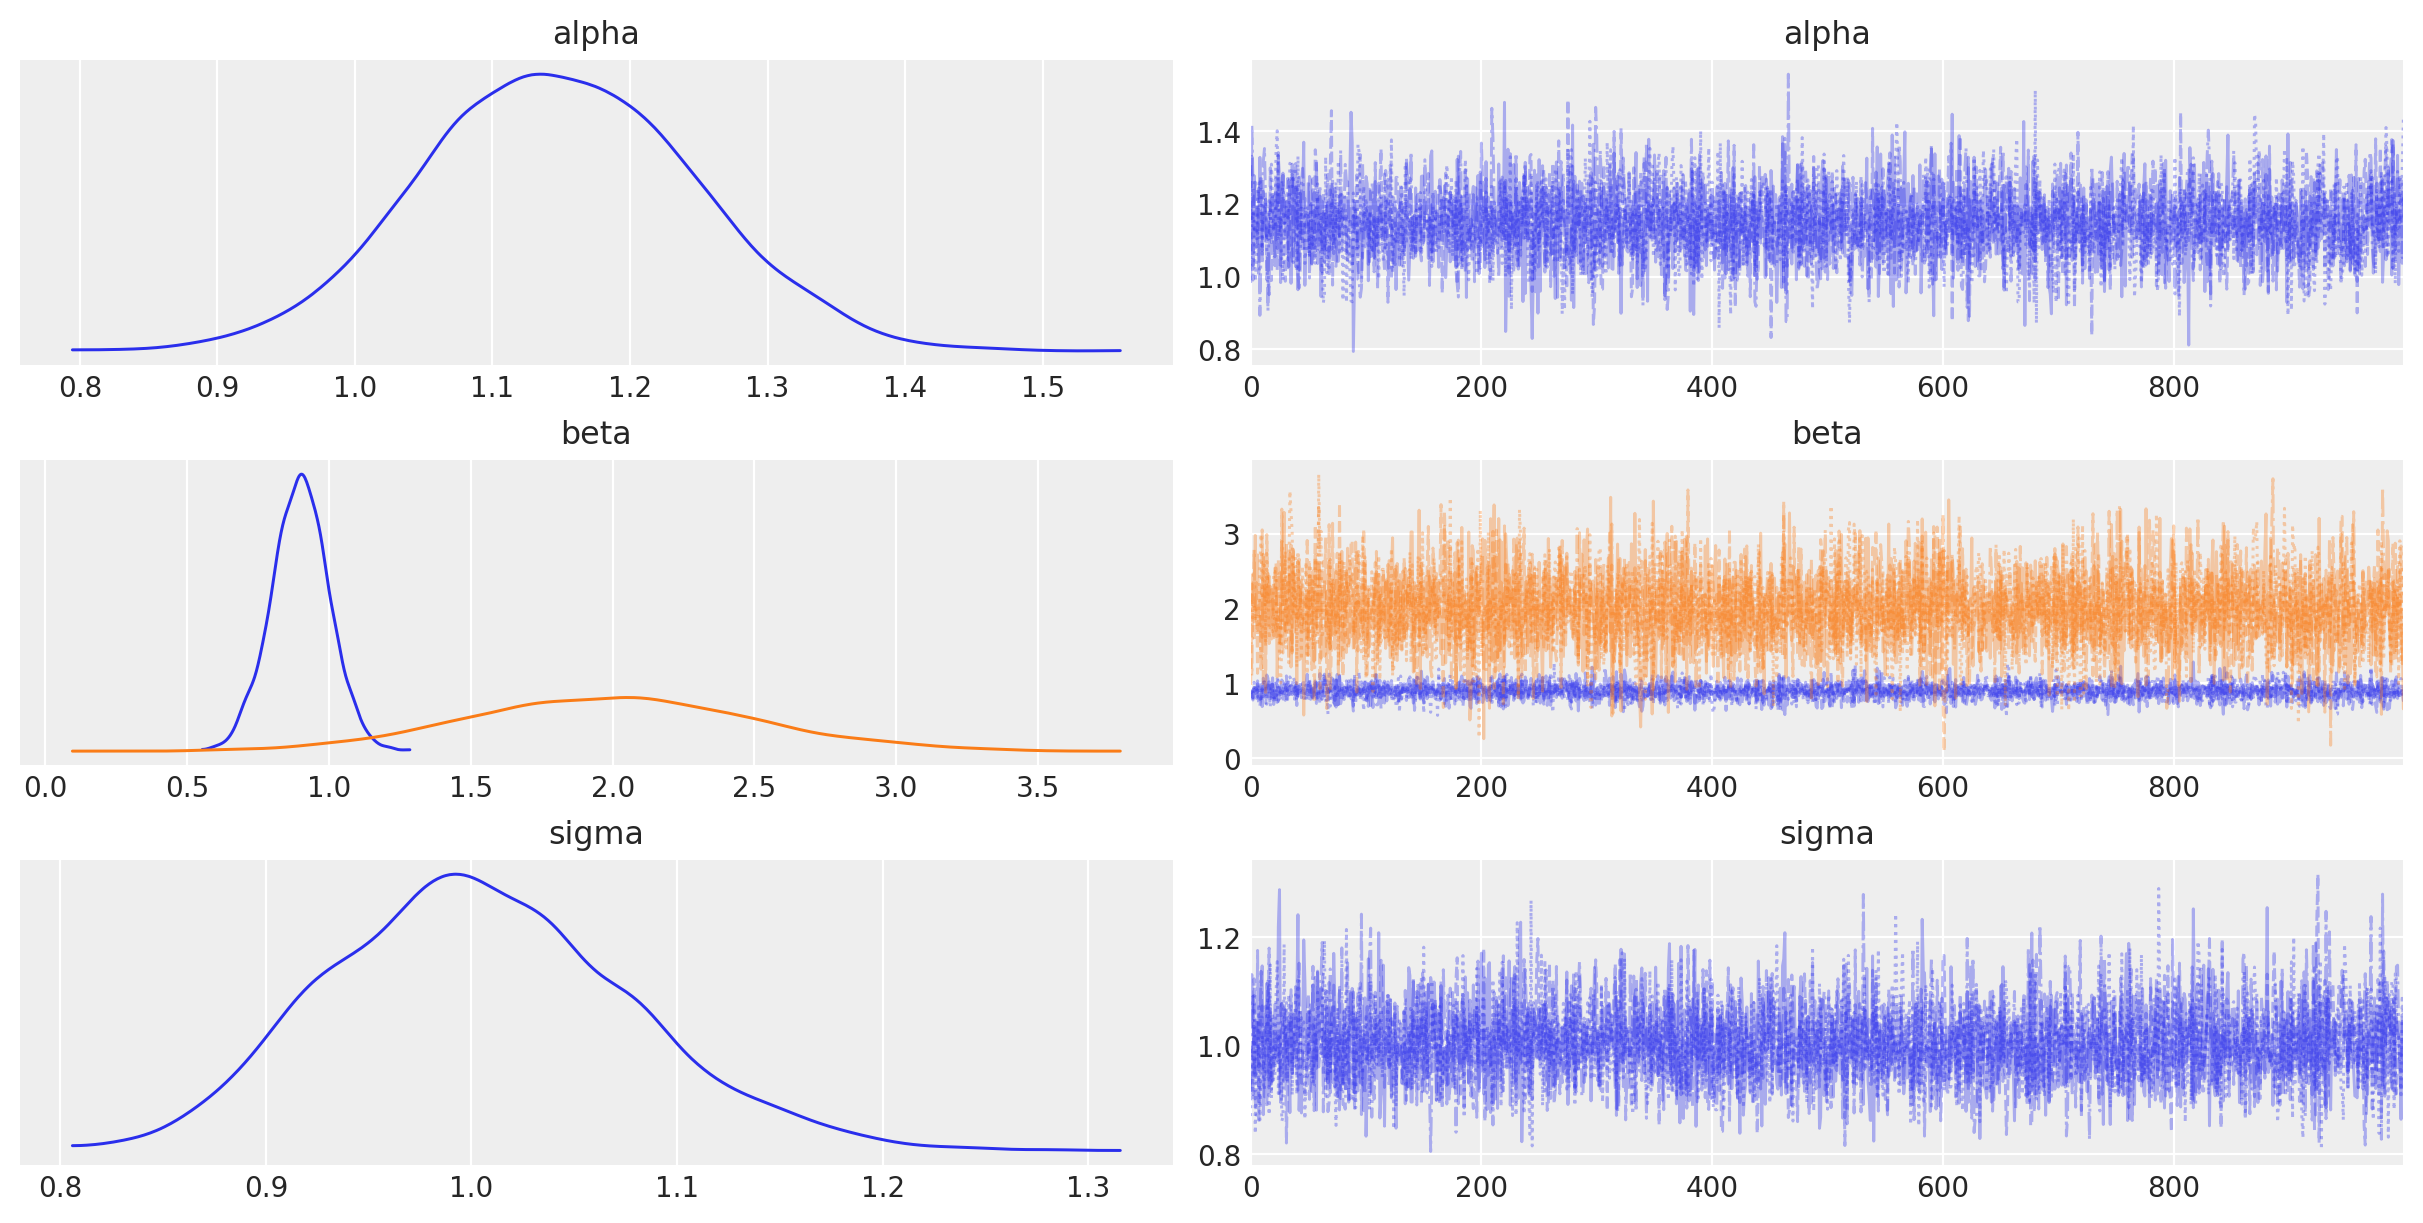

In [7]:
az.plot_trace(idata, combined=True);

In [8]:
az.summary(idata, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    1.15  0.10    0.96     1.33       0.00      0.0   4969.68   3301.93   
beta[0]  0.90  0.10    0.69     1.08       0.00      0.0   5619.10   2823.95   
beta[1]  1.99  0.51    1.00     2.95       0.01      0.0   5944.36   2923.86   
sigma    1.00  0.07    0.88     1.15       0.00      0.0   6376.23   3482.27   

         r_hat  
alpha      1.0  
beta[0]    1.0  
beta[1]    1.0  
sigma      1.0

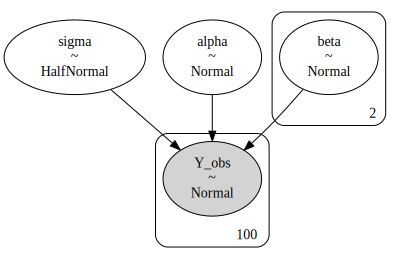

In [11]:
pm.model_to_graphviz(basic_model)

---

# Case study 1: Educational Outcomes for Hearing-impaired Children

> This anonymized dataset is taken from the Listening and Spoken Language Data Repository (LSL-DR), an international data repository that tracks the demographics and longitudinal outcomes for children who have hearing loss and are enrolled in programs focused on supporting listening and spoken language development. Researchers are interested in discovering factors related to improvements in educational outcomes within these programs.

In [73]:
import pandas as pd
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

score  male  siblings  family_inv  non_english  prev_disab  age_test  \
0     40     0       2.0         2.0        False         NaN        55   
1     31     1       0.0         NaN        False         0.0        53   
2     83     1       1.0         1.0         True         0.0        52   
3     75     0       3.0         NaN        False         0.0        55   
5     62     0       0.0         4.0        False         1.0        50   

   non_severe_hl  mother_hs  early_ident  non_white  
0            1.0        NaN        False      False  
1            0.0        0.0        False      False  
2            1.0        NaN        False       True  
3            0.0        1.0        False      False  
5            0.0        NaN        False      False

In [74]:
len(test_scores)

207

In [75]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape
print(N)
print(D)

101
10


In [76]:
X.head()

male  siblings  family_inv  non_english  prev_disab  age_test  \
7  -1.004938  1.078165    2.227502     2.480475    1.782293 -0.978004   
12  0.985234 -0.080289   -0.911722    -0.399157   -0.555520 -1.562492   
14 -1.004938  1.078165   -0.911722    -0.399157   -0.555520  1.359947   
19  0.985234 -1.238742    1.181094    -0.399157   -0.555520 -0.978004   
21  0.985234 -0.080289    1.181094    -0.399157    1.782293  1.359947   

    non_severe_hl  mother_hs  early_ident  non_white  
7        1.179344   0.616250    -0.772789   1.132532  
12       1.179344   0.616250     1.281203  -0.874235  
14       1.179344   0.616250     1.281203   1.132532  
19       1.179344   0.616250    -0.772789   1.132532  
21      -0.839533  -1.606652     1.281203   1.132532

> while there are several potential predictors in the LSL-DR dataset, it is difficult a priori to determine which ones are relevant for constructing an effective statistical model. There are a number of approaches for conducting variable selection, but a popular automated method is regularization, whereby ineffective covariates are shrunk towards zero via regularization (a form of penalization) if they do not contribute to predicting outcomes.
> 
> You may have heard of regularization from machine learning or classical statistics applications, where methods like the lasso or ridge regression shrink parameters towards zero by applying a penalty to the size of the regression parameters. In a Bayesian context, we apply an appropriate prior distribution to the regression coefficients. One such prior is the **hierarchical regularized horseshoe**, which uses two regularization strategies, one global and a set of local local parameters, one for each coefficient. The key to making this work is by selecting a long-tailed distribution as the shrinkage priors, which allows some to be nonzero, while pushing the rest towards zero.

See https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html for further explanation.

> One catch is that the parameterization of the prior requires a pre-specified value `D0`, which represents the true number of non-zero coefficients. Fortunately, a reasonable guess at this value is all that is required, and it need only be within an order of magnitude of the true number. Let’s use half the number of predictors as our guess:

In [77]:
D0 = int(D / 2)
D0

5

https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.InverseGamma.html#pymc.InverseGamma

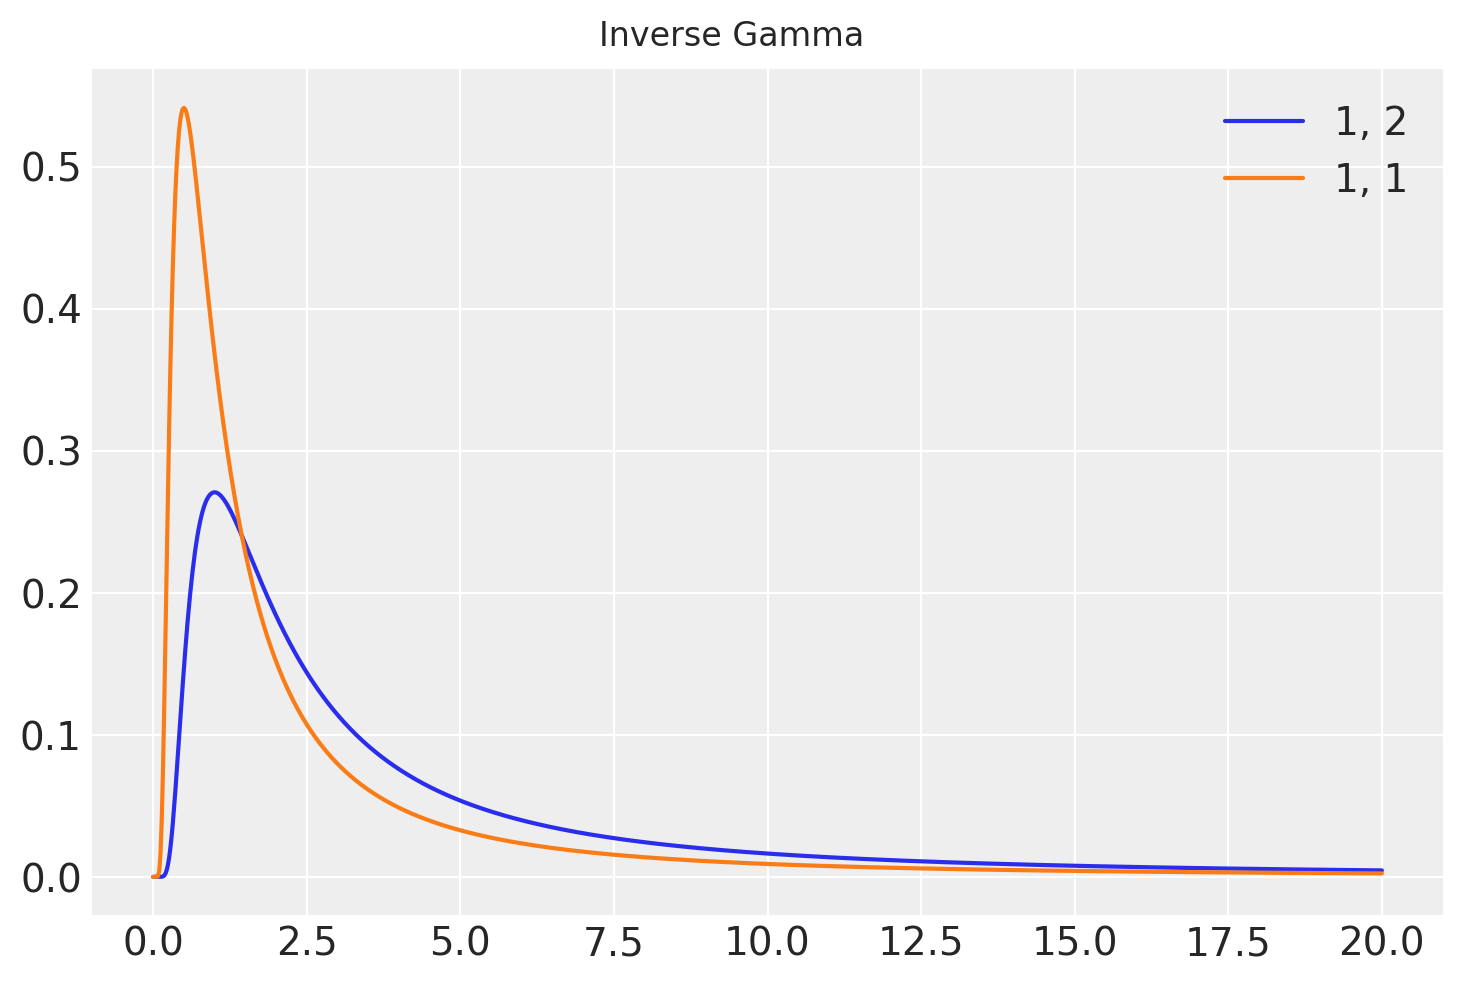

In [78]:
def inverse_gamma_pdf(x, alpha, beta):
    return stats.invgamma.pdf(x, a=alpha, loc=0, scale=beta)

x_gamma = np.linspace(0, 20, 1000)
y_gamma = inverse_gamma_pdf(x_gamma, alpha=1, beta=2)
plt.plot(x_gamma, y_gamma, label="1, 2")
y_gamma = inverse_gamma_pdf(x_gamma, alpha=1, beta=1)
plt.plot(x_gamma, y_gamma, label="1, 1")
plt.suptitle("Inverse Gamma")
plt.legend(loc=0)
plt.show()

In [79]:
coords = {"predictors": X.columns.values}
coords

{'predictors': array(['male', 'siblings', 'family_inv', 'non_english', 'prev_disab',
        'age_test', 'non_severe_hl', 'mother_hs', 'early_ident',
        'non_white'], dtype=object)}

In [66]:
X.values

array([[-1.0049383 ,  1.07816458,  2.22750212, ...,  0.61624995,
        -0.77278883,  1.13253179],
       [ 0.98523363, -0.08028885, -0.9117218 , ...,  0.61624995,
         1.28120254, -0.87423507],
       [-1.0049383 ,  1.07816458, -0.9117218 , ...,  0.61624995,
         1.28120254,  1.13253179],
       ...,
       [ 0.98523363,  1.07816458,  0.13468617, ...,  0.61624995,
        -0.77278883,  1.13253179],
       [-1.0049383 ,  1.07816458,  1.18109415, ...,  0.61624995,
         1.28120254, -0.87423507],
       [ 0.98523363,  1.07816458, -0.9117218 , ...,  0.61624995,
        -0.77278883, -0.87423507]])

In [ ]:
import pytensor.tensor as at

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:

    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 2, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 0.1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + at.dot(X.values, beta), sigma, observed=y.values)

In [85]:
test_scores.score.mean()

84.19323671497584

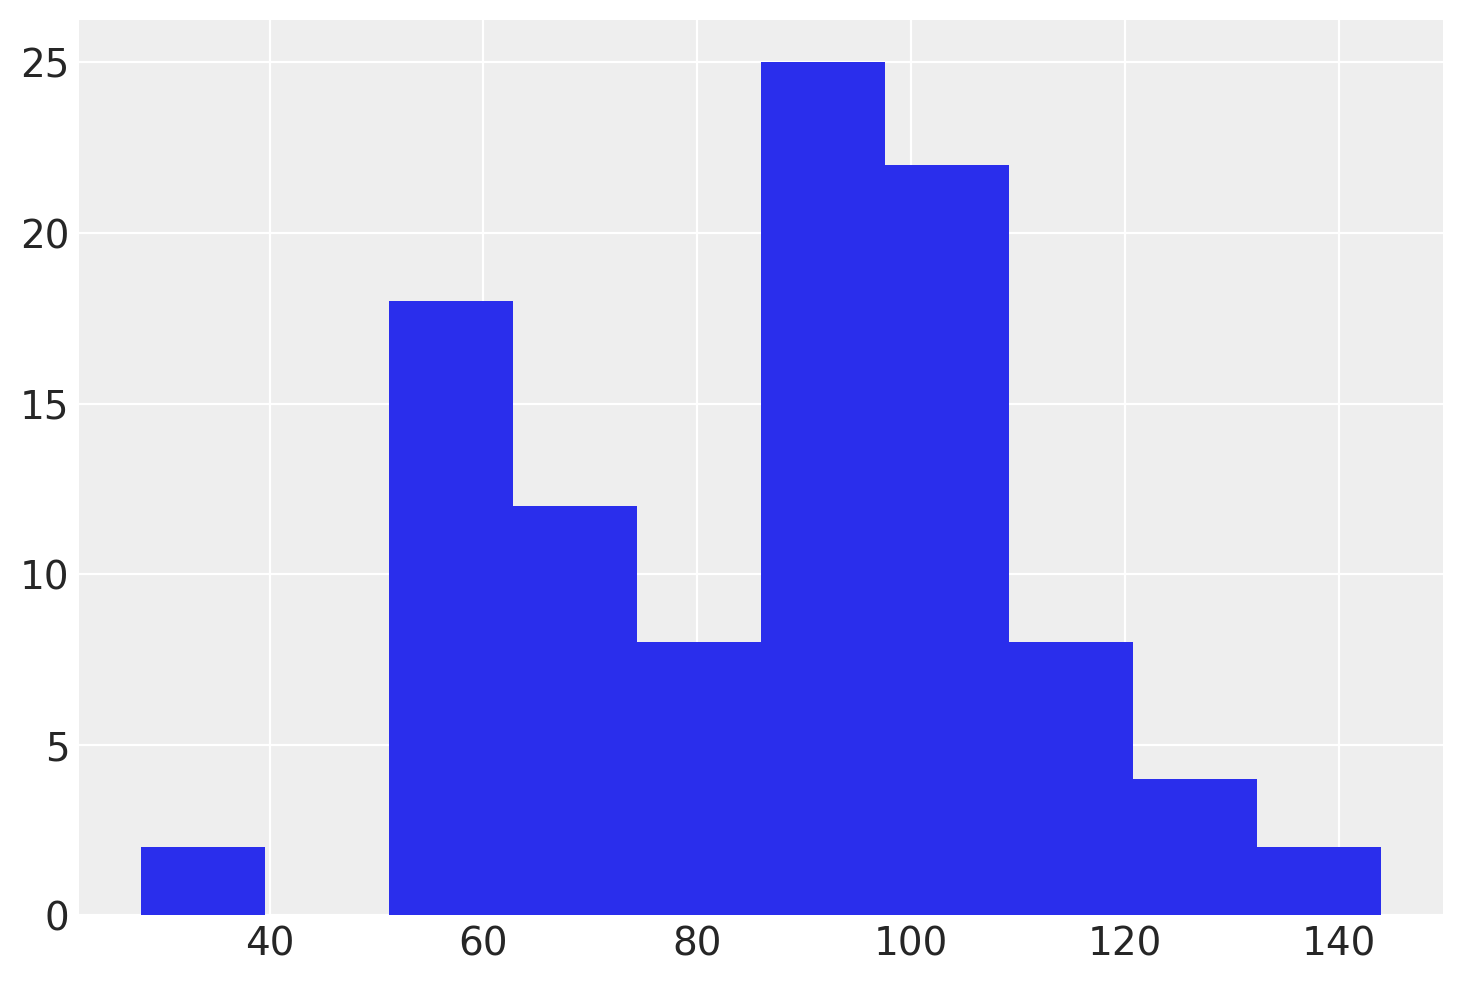

In [87]:
y.hist();

In [83]:
y.mean()

87.76237623762377

In [158]:
import pytensor.tensor as at

with pm.Model(coords=coords) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", nu=2, sigma=D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", nu=2, dims="predictors")
    c2 = pm.InverseGamma("c2", alpha=1, beta=0.1)
    z = pm.Normal("z", mu=0.0, sigma=1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", mu=100, sigma=25.0)  # 100 because y-mean is close to 100??

    scores = pm.Normal(
        "scores",
        # X.values is matrix of data
        # beta is coefficients (stochastic variable)
        mu=beta0 + at.dot(X.values, beta),
        sigma=sigma,
        observed=y.values
    )

In [159]:
coeff_temp = np.array([2, 20])
X_temp = np.array([[2, 3], [20, 30]])
X_temp

array([[ 2,  3],
       [20, 30]])

In [160]:
coeff_temp * X_temp

array([[  4,  60],
       [ 40, 600]])

In [161]:
X_temp.dot(coeff_temp)

array([ 64, 640])

In [162]:
(coeff_temp * X_temp).sum(axis=1)

array([ 64, 640])

> In PyMC, variables with purely positive priors like InverseGamma are transformed with a log transform. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named <variable-name>_log) is added to the model for sampling. Variables with priors that constrain them on two sides, like Beta or Uniform, are also transformed to be unconstrained but with a log odds transform.


> We are also going to take advantage of named dimensions in PyMC and ArviZ by passing the input variable names into the model as coordinates called “predictors”. This will allow us to pass this vector of names as a replacement for the shape integer argument in the vector-valued parameters. The model will then associate the appropriate name with each latent parameter that it is estimating. This is a little more work to set up, but will pay dividends later when we are working with our model output.

> Notice that we have wrapped the calculation of beta in a Deterministic PyMC class. You can read more about this in detail below, but this ensures that the values of this deterministic variable is retained in the sample trace.

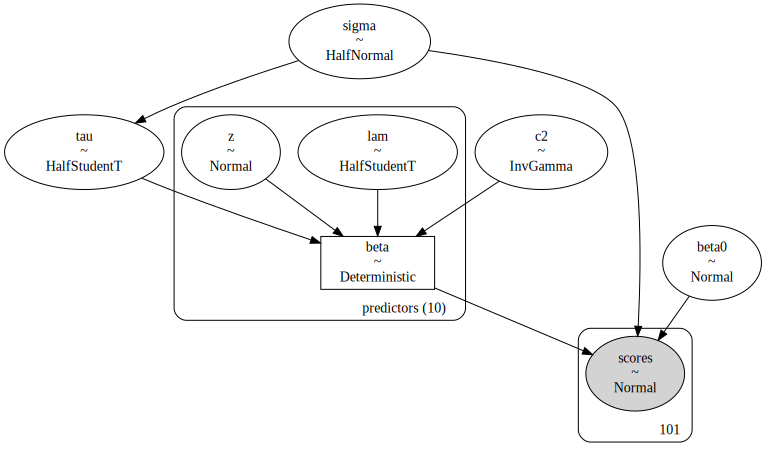

In [163]:
pm.model_to_graphviz(test_score_model)

> Before we proceed further, let’s see what the model does before it sees any data. We can conduct prior predictive sampling to generate simulated data from the model. Then, let’s compare these simulations to the actual test scores in the dataset.

In [164]:
num_samples = 1000

with test_score_model:
    prior_samples = pm.sample_prior_predictive(num_samples)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


In [165]:
prior_samples_data = prior_samples.prior_predictive['scores'].data[0]
prior_samples_data.shape

(1000, 101)

In [166]:
# find median of each column e.g. median of all samples per observation
prior_expected_values = np.median(prior_samples_data, axis=0)
assert len(prior_expected_values) == len(X)
prior_expected_values.mean()

100.52032552704797

In [167]:
assert len(prior_samples_data) == num_samples
assert prior_samples_data.shape[1] == len(X)

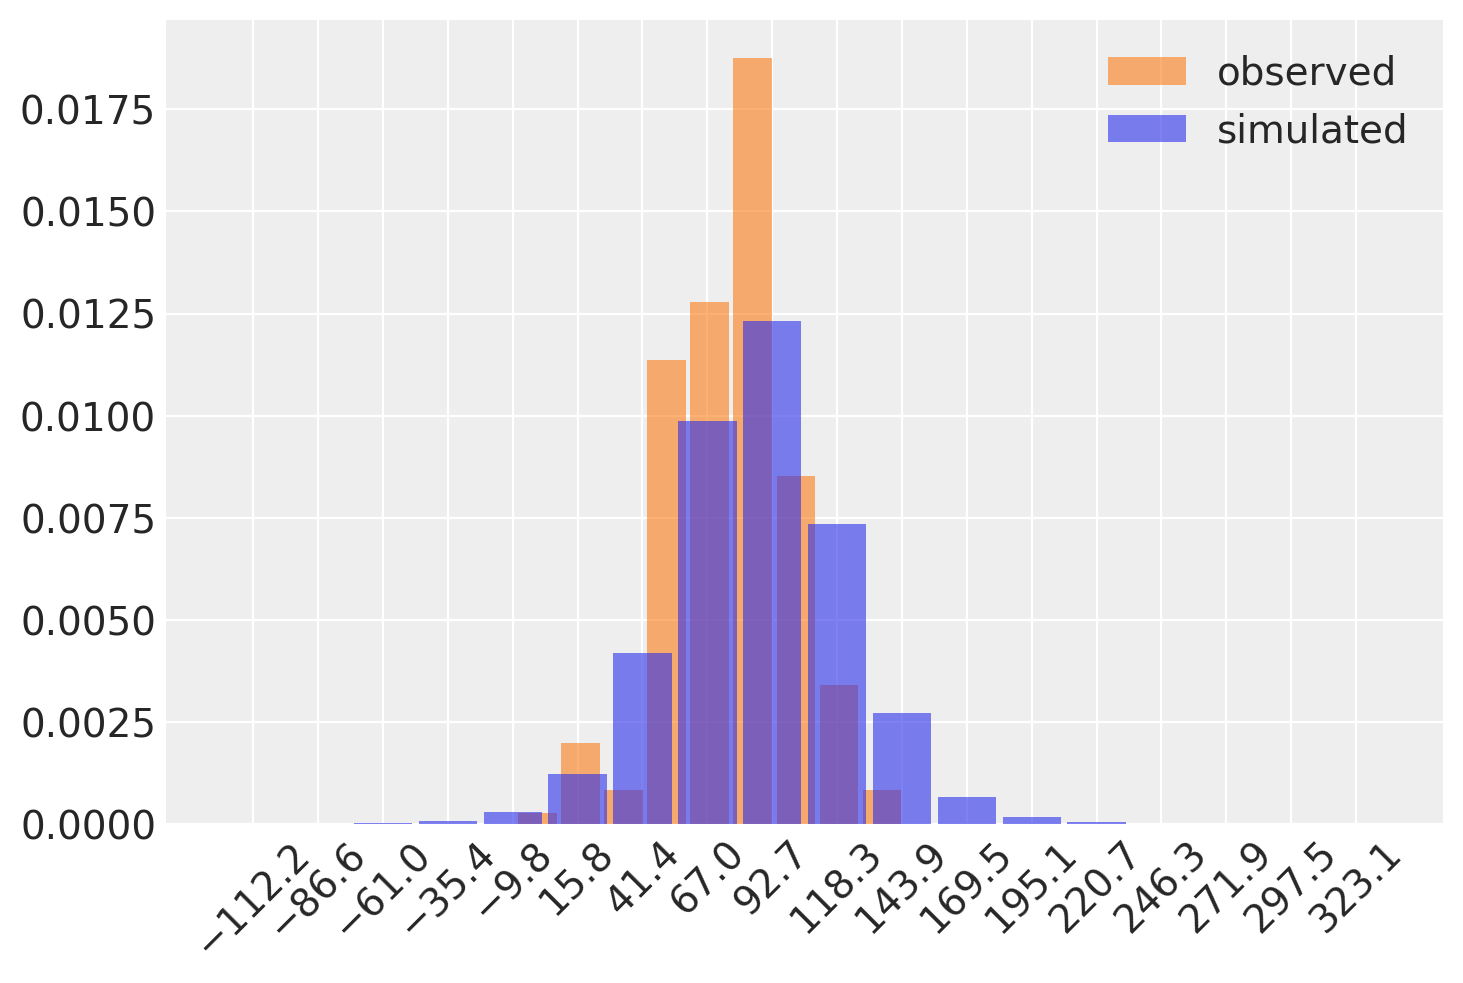

In [168]:
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

> How do we know if this is reasonable or not? This requires some domain knowledge of the problem. Here, we are trying to predict the outcomes of test scores. If our model was predicting values in the thousands, or lots of negative values, while excluding scores that are plausible, then we have misspecified our model. You can see here that the support of the distribution of simulated data completely overlaps the support of the observed distribution of scores; this is a good sign! There are a few negative values and a few that are probably too large to be plausible, but nothing to worry about.

In [177]:
samples_prior_coefficients = pd.DataFrame(prior_samples.prior['beta'][0], columns=X.columns.values)
samples_prior_coefficients.mean()

male             0.026545
siblings         0.014735
family_inv       0.021322
non_english     -0.006682
prev_disab       0.010653
age_test        -0.030580
non_severe_hl    0.054800
mother_hs       -0.018337
early_ident     -0.018678
non_white       -0.043571
dtype: float64

In [179]:
samples_prior_coefficients.std()

male             0.688244
siblings         0.587836
family_inv       0.550688
non_english      0.486618
prev_disab       0.638527
age_test         0.563305
non_severe_hl    0.598739
mother_hs        0.575193
early_ident      0.740991
non_white        0.801203
dtype: float64

# Model Fitting

> Now for the easy part: PyMC’s “Inference Button” is the call to sample. We will let this model tune for a little longer than the default value (1000 iterations). This gives the NUTS sampler a little more time to tune itself adequately.

In [180]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 7 seconds.


> Notice that we have a few warnings here about divergences. These are samples where NUTS was not able to make a valid move across the posterior distribution, so the resulting points are probably not representative samples from the posterior. There aren’t many in this example, so it’s nothing to worry about, but let’s go ahead and follow the advice and increase target_accept from its default value of 0.9 to 0.99.

In [181]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.


> Since the target acceptance rate is larger, the algorithm is being more conservative with its leapfrog steps, making them smaller. The price we pay for this is that each sample takes longer to complete. However, the warnings are now gone, and we have a clean posterior sample!

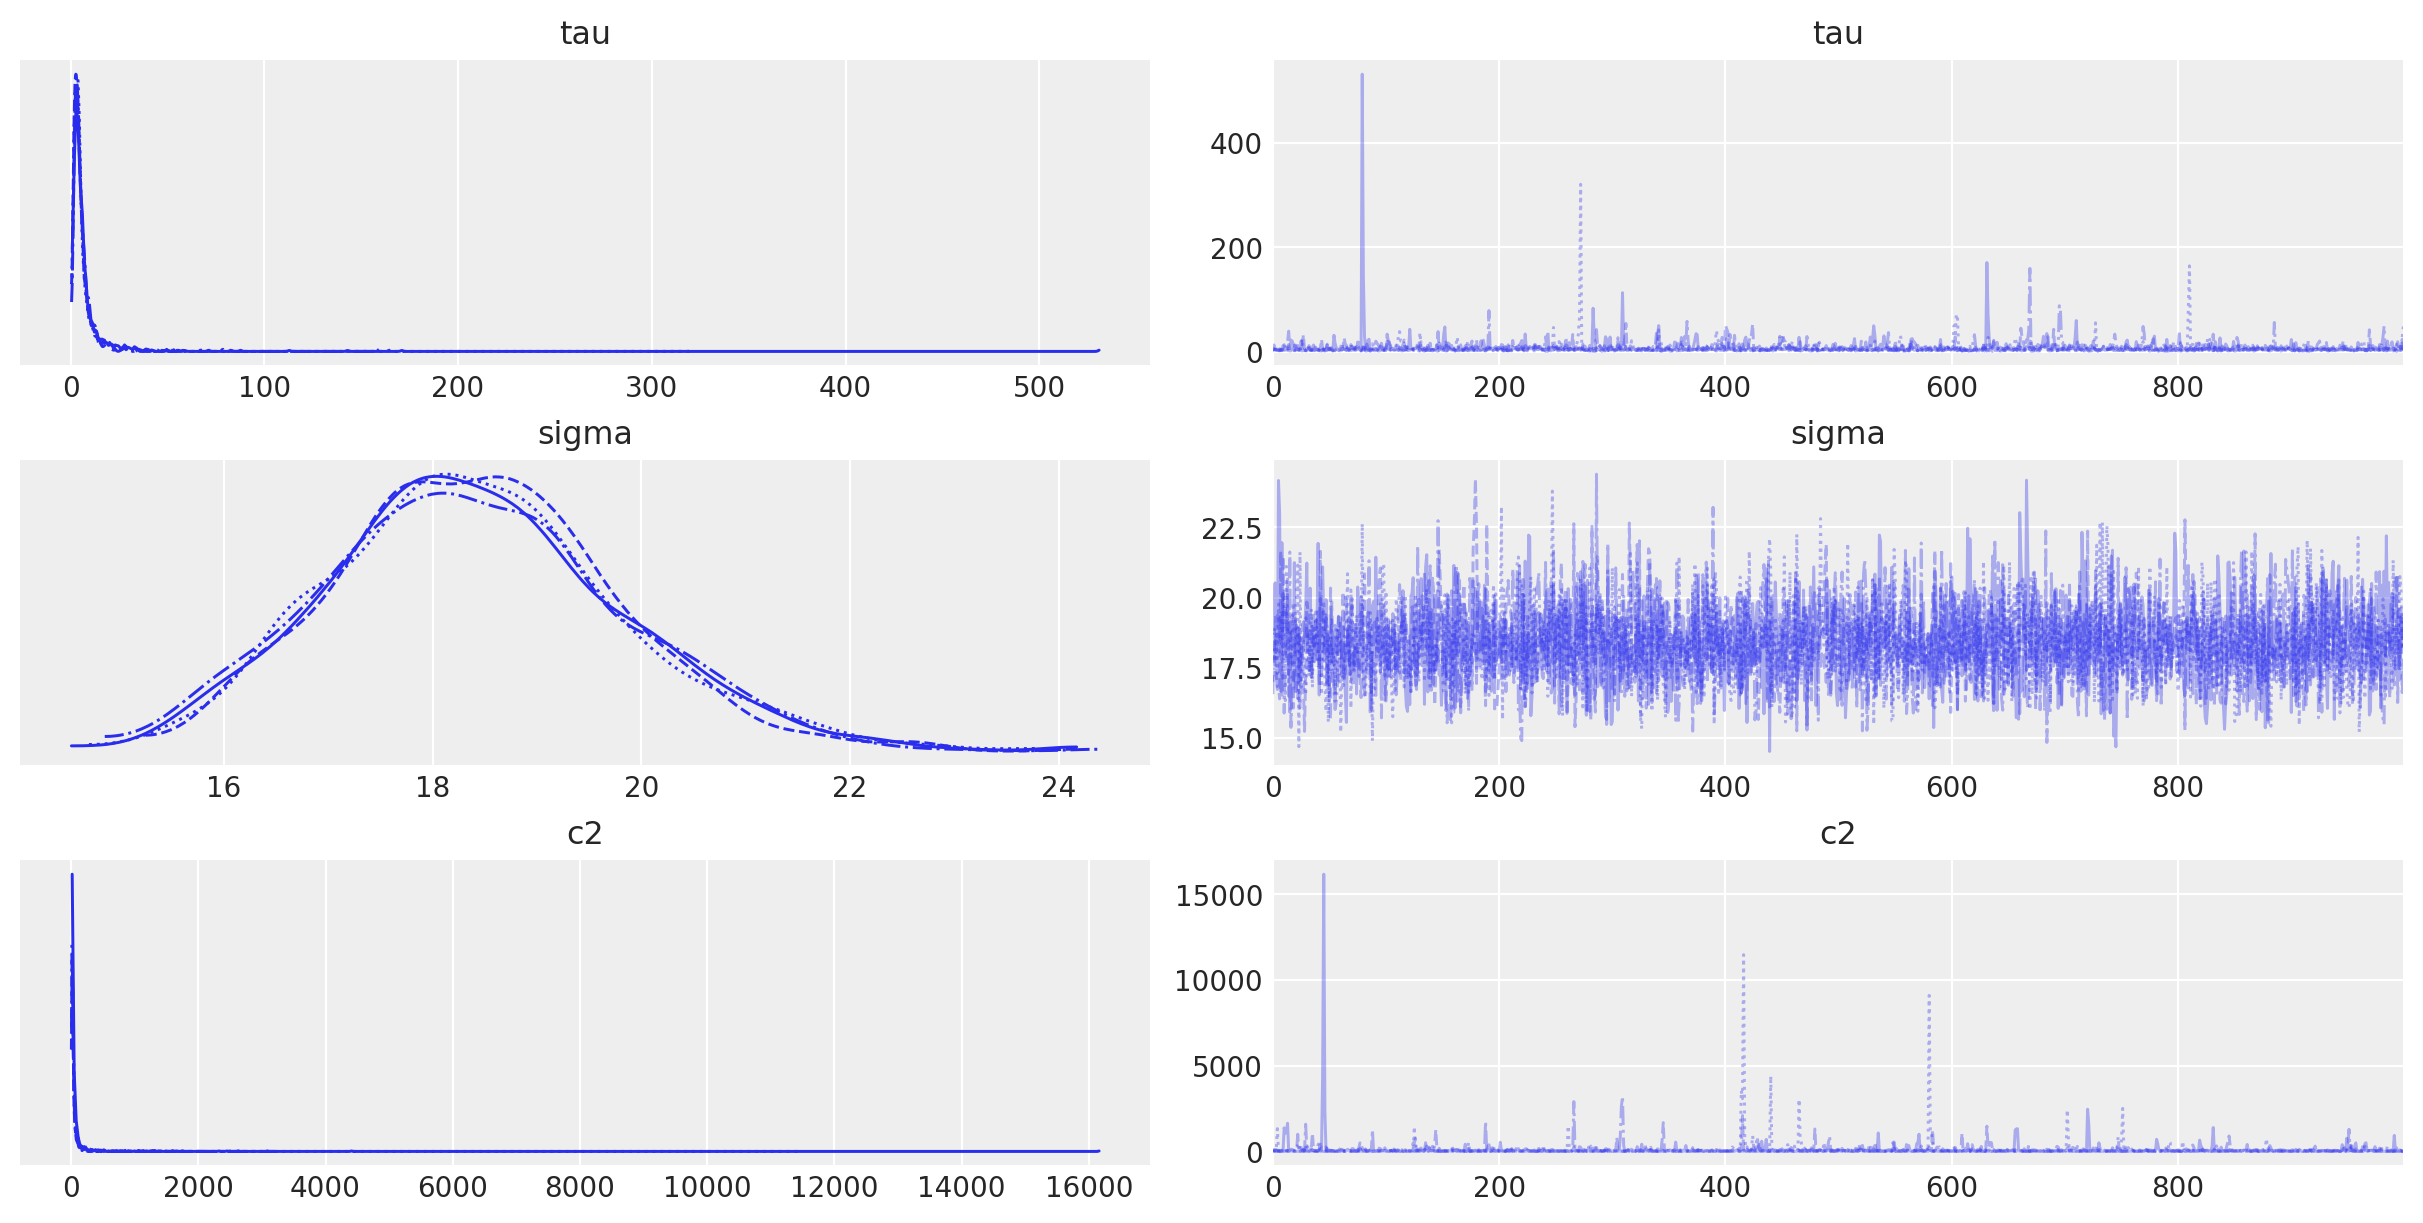

In [182]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"]);

> Do these look okay? Well, each of the densities on the left side for each parameter look pretty similar to the others, which means they have converged to the same posterior distribution (be it the correct one or not). The homogeneity of the trace plots on the right are also a good sign; there is no trend or pattern to the time series of sampled values. Note that c2 and tau occasionally sample extreme values, but this is expected from heavy-tailed distributions.

> The next easy model-checking step is to see if the NUTS sampler performed as expected. An energy plot is a way of checking if the NUTS algorithm was able to adequately explore the posterior distribtion. If it was not, one runs the risk of biased posterior estimates when parts of the posterior are not visited with adequate frequency. The plot shows two density estimates: one is the marginal energy distribution of the sampling run and the other is the distribution of the energy transitions between steps. This is all a little abstract, but all we are looking for is for the distributions to be similar to one another. Ours does not look too bad.

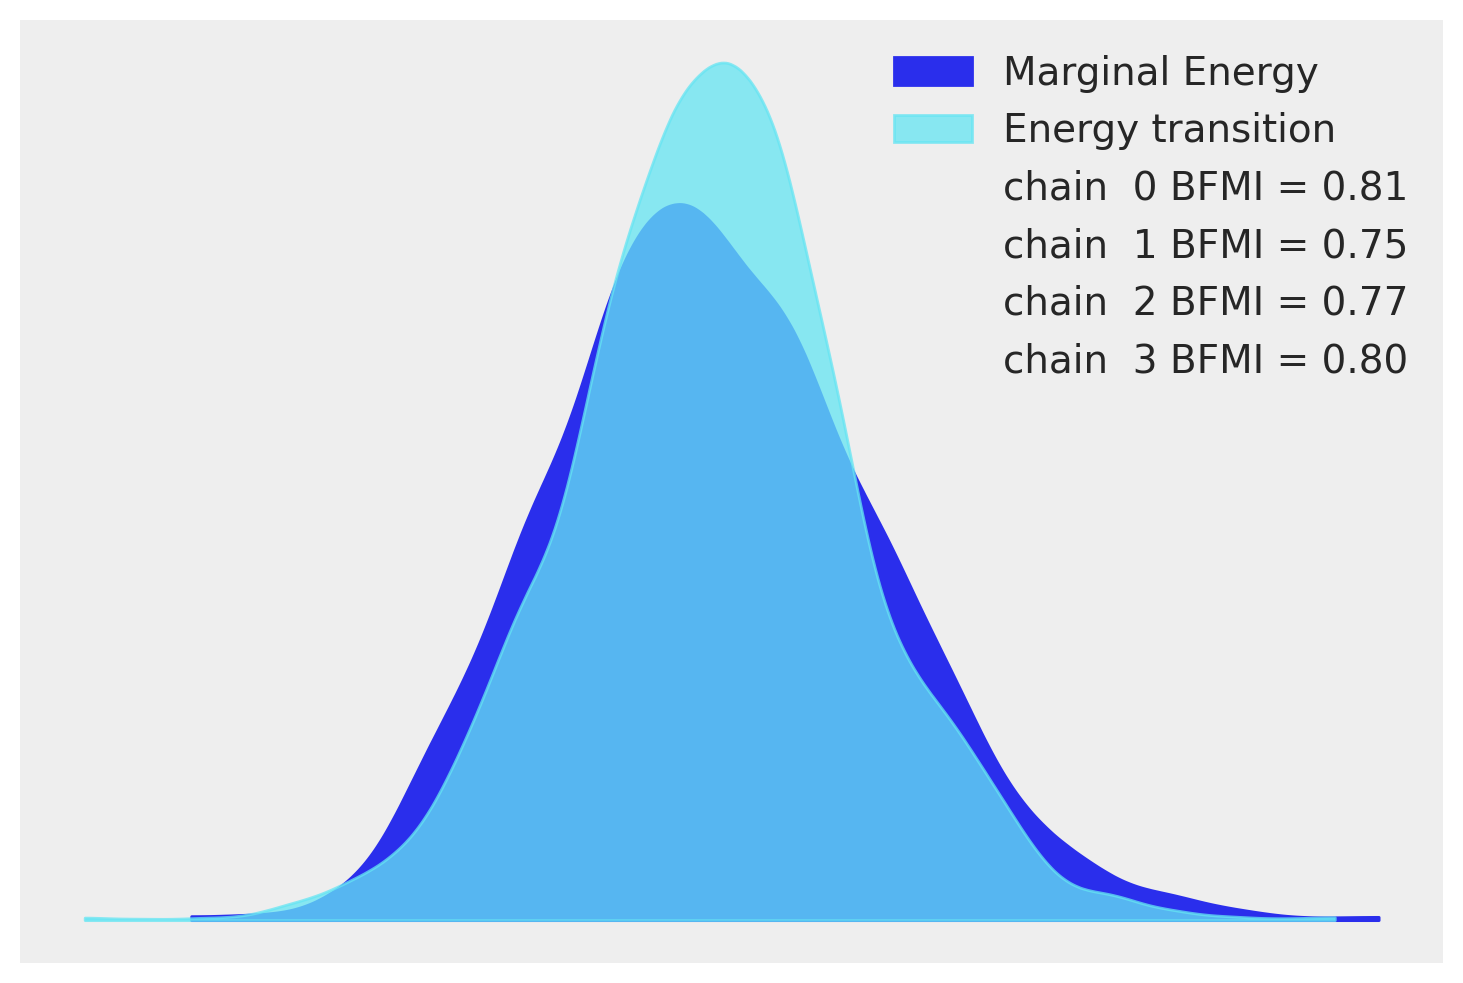

In [183]:
az.plot_energy(idata);

> Ultimately, we are interested in the estimates of `beta`, the set of **predictor coefficients**. Passing `beta` to `plot_trace` would generate a very crowded plot, so we will use `plot_forest` instead, which is designed to handle vector-valued parameters.

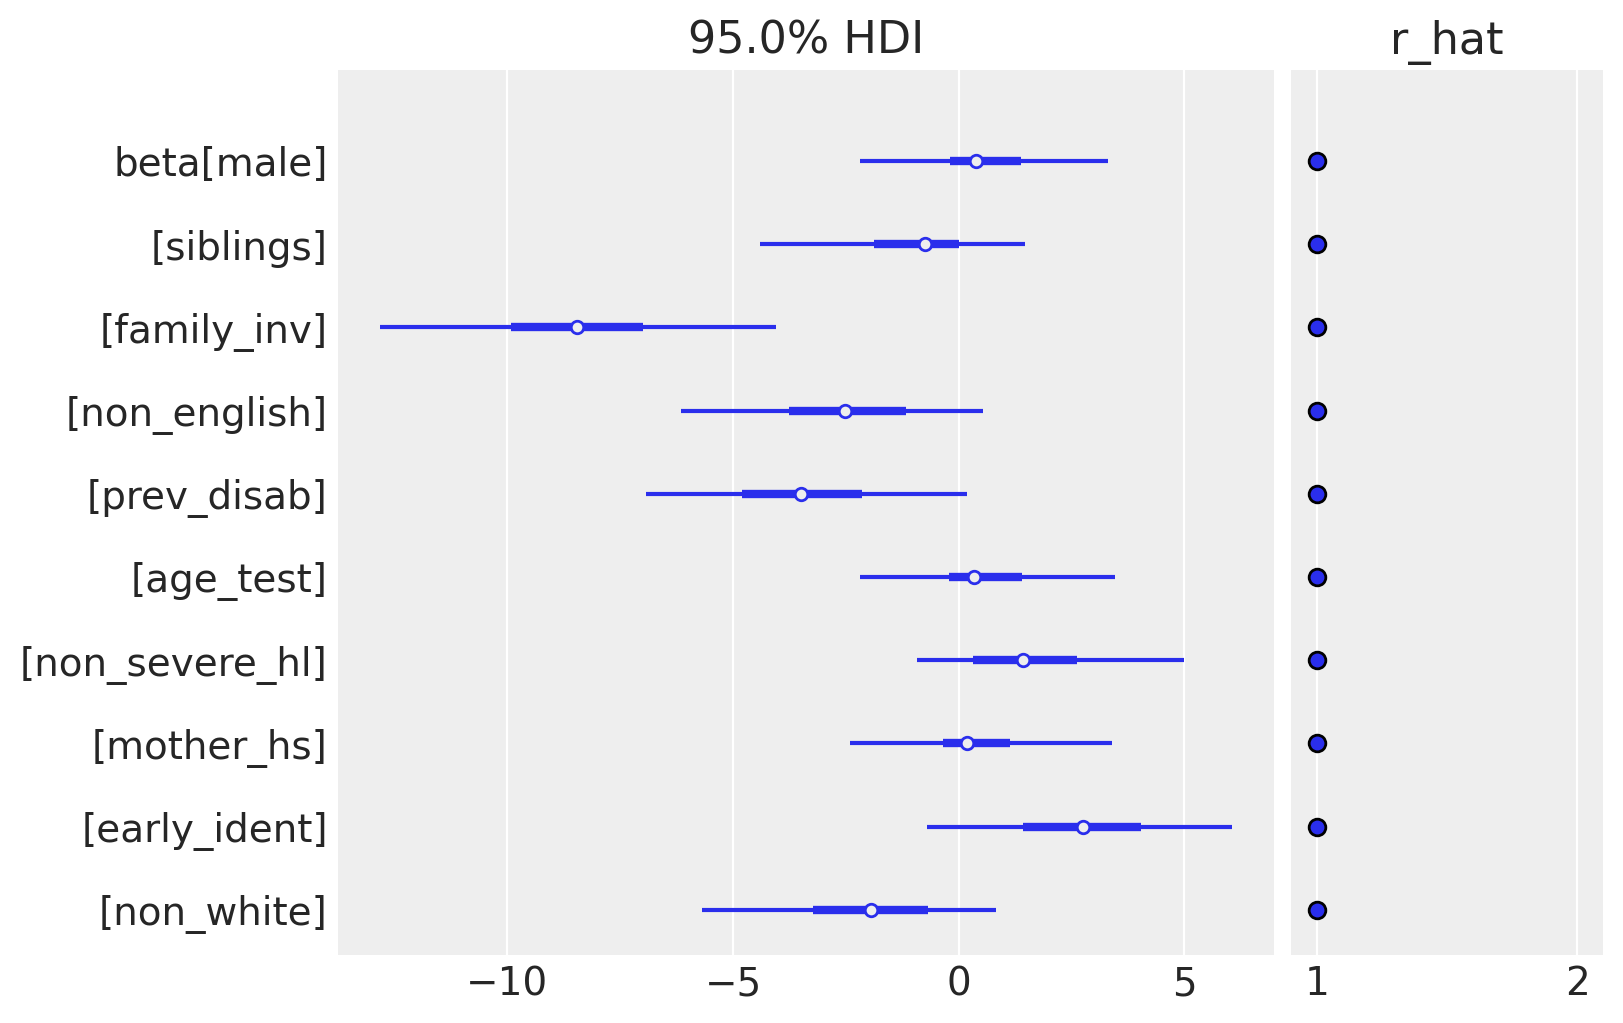

In [184]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

# Case Study 2 - Times Series w/ Switch point

> Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period. Unfortunately, we also have a pair of years with missing data, identified as missing by a nan in the pandas Series. These missing values will be automatically imputed by PyMC.

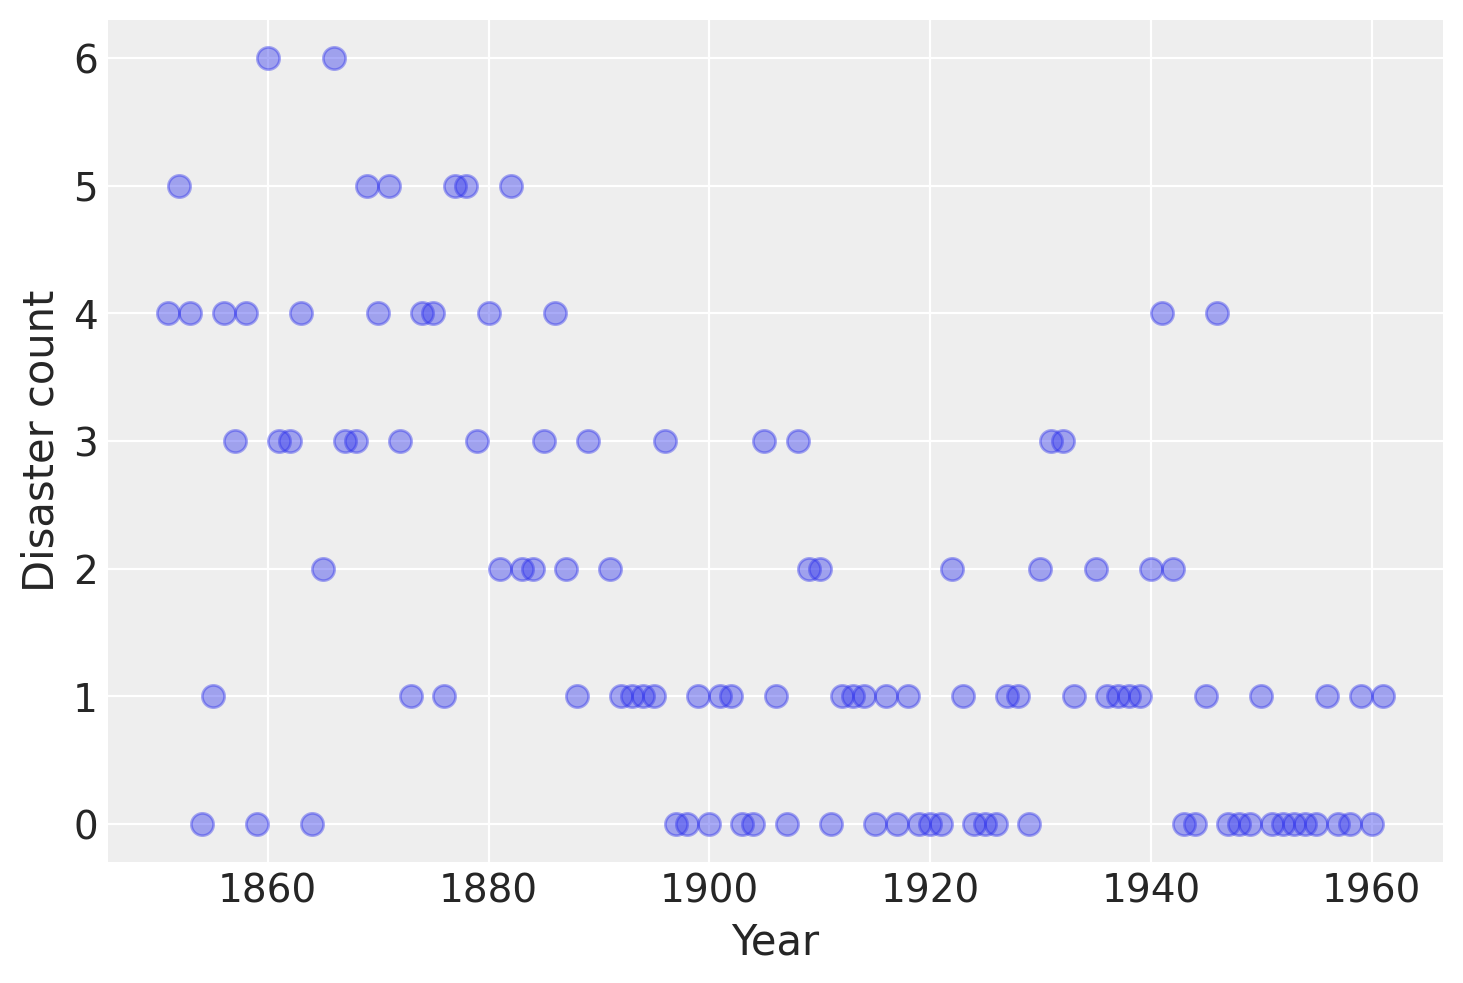

In [4]:
# fmt: off
import pandas as pd
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [5]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # We are basically defining two lambdas for the poisson distribution,
    # one that corresponds to before the switch, and one for after
    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/usr/local/lib/python3.10/site-packages/pymc/model.py:1371: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/usr/local/lib/python3.10/site-packages/pymc/model.py:1400: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


> Unfortunately, because they are discrete variables and thus have no meaningful gradient, we cannot use NUTS for sampling switchpoint or the missing disaster observations. Instead, we will sample using a Metropolis step method, which implements adaptive Metropolis-Hastings, because it is designed to handle discrete values. PyMC automatically assigns the correct sampling algorithms.

In [6]:
with disaster_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_missing]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 8 seconds.


> In the trace plot below we can see that there’s about a 10 year span that’s plausible for a significant change in safety, but a 5 year span that contains most of the probability mass. The distribution is jagged because of the jumpy relationship between the year switchpoint and the likelihood; the jaggedness is not due to sampling error.

/usr/local/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


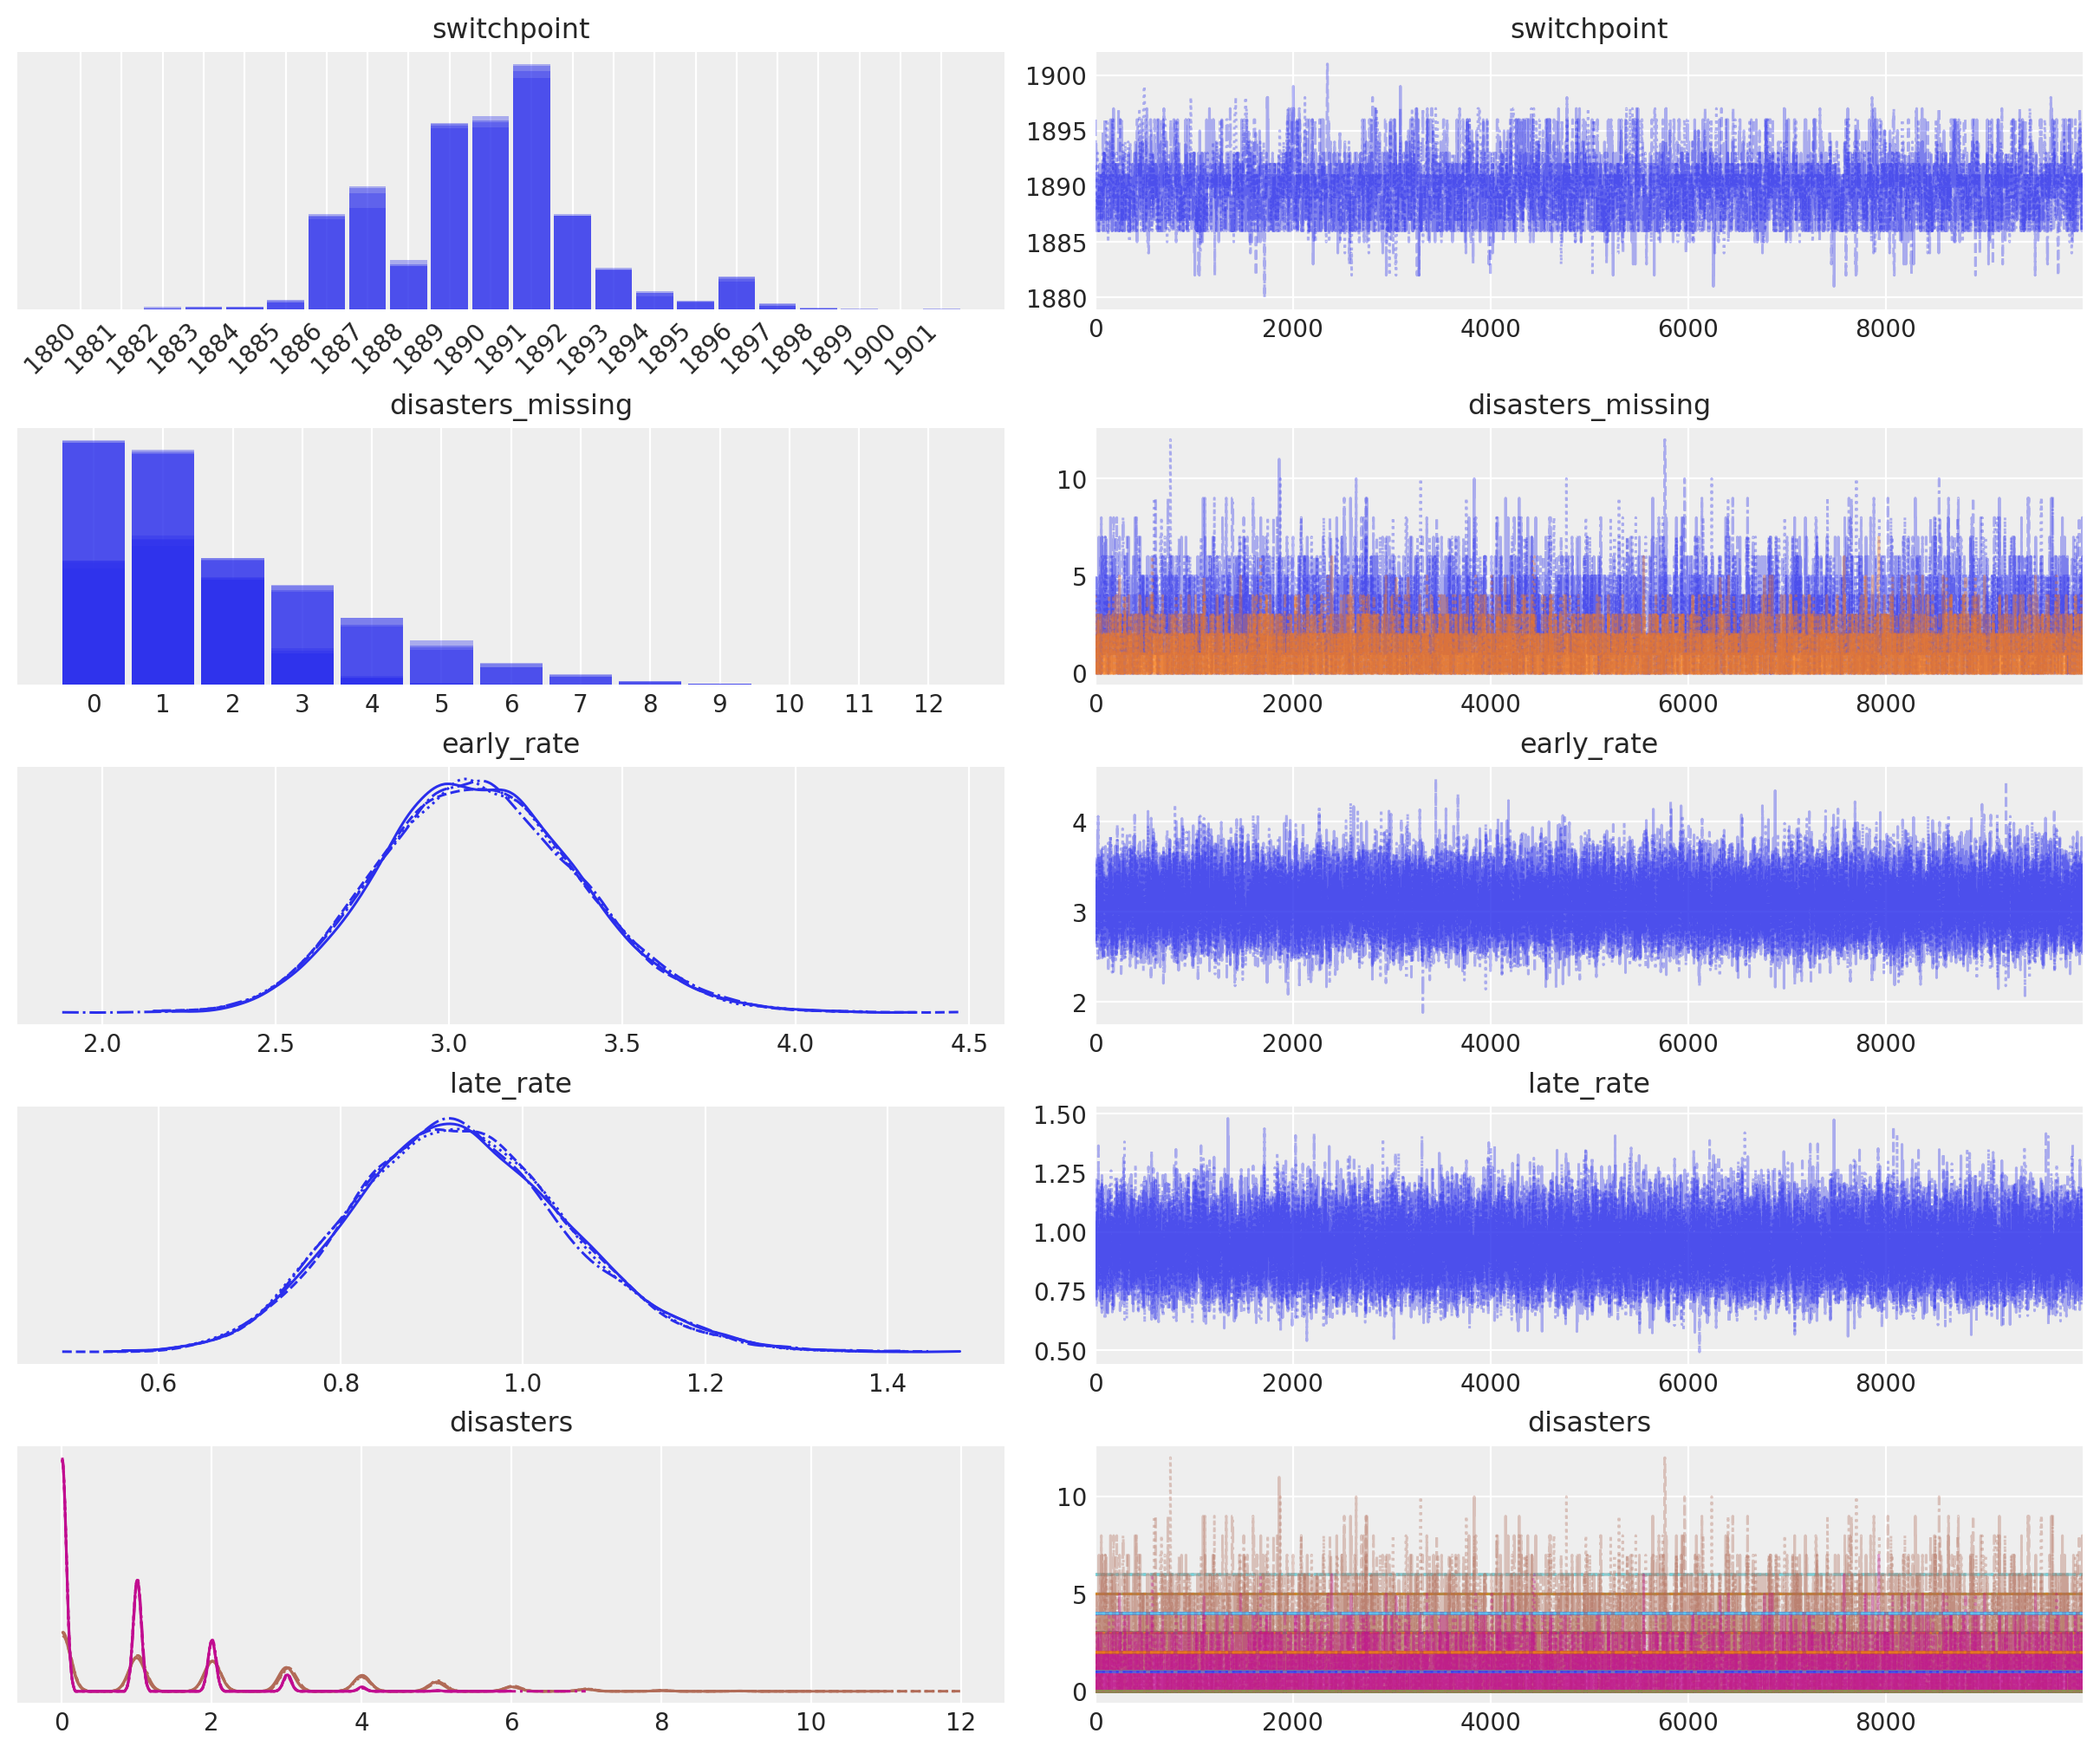

In [7]:
axes_arr = az.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

In [8]:
trace = idata.posterior.stack(draws=("chain", "draw"))

In [9]:
trace["early_rate"].data.mean()

3.0877913333326994

In [10]:
trace["late_rate"].data.mean()

0.9311368463186074

In [11]:
len(trace["late_rate"].data)

40000

In [12]:
trace["switchpoint"].mean().values

array(1889.8211)

In [13]:
trace["late_rate"].to_pandas()

chain  draw
0      0       1.068352
       1       0.920077
       2       1.029139
       3       0.963312
       4       0.916700
                 ...   
3      9995    1.006736
       9996    0.968104
       9997    0.842484
       9998    0.905754
       9999    1.008286
Length: 40000, dtype: float64

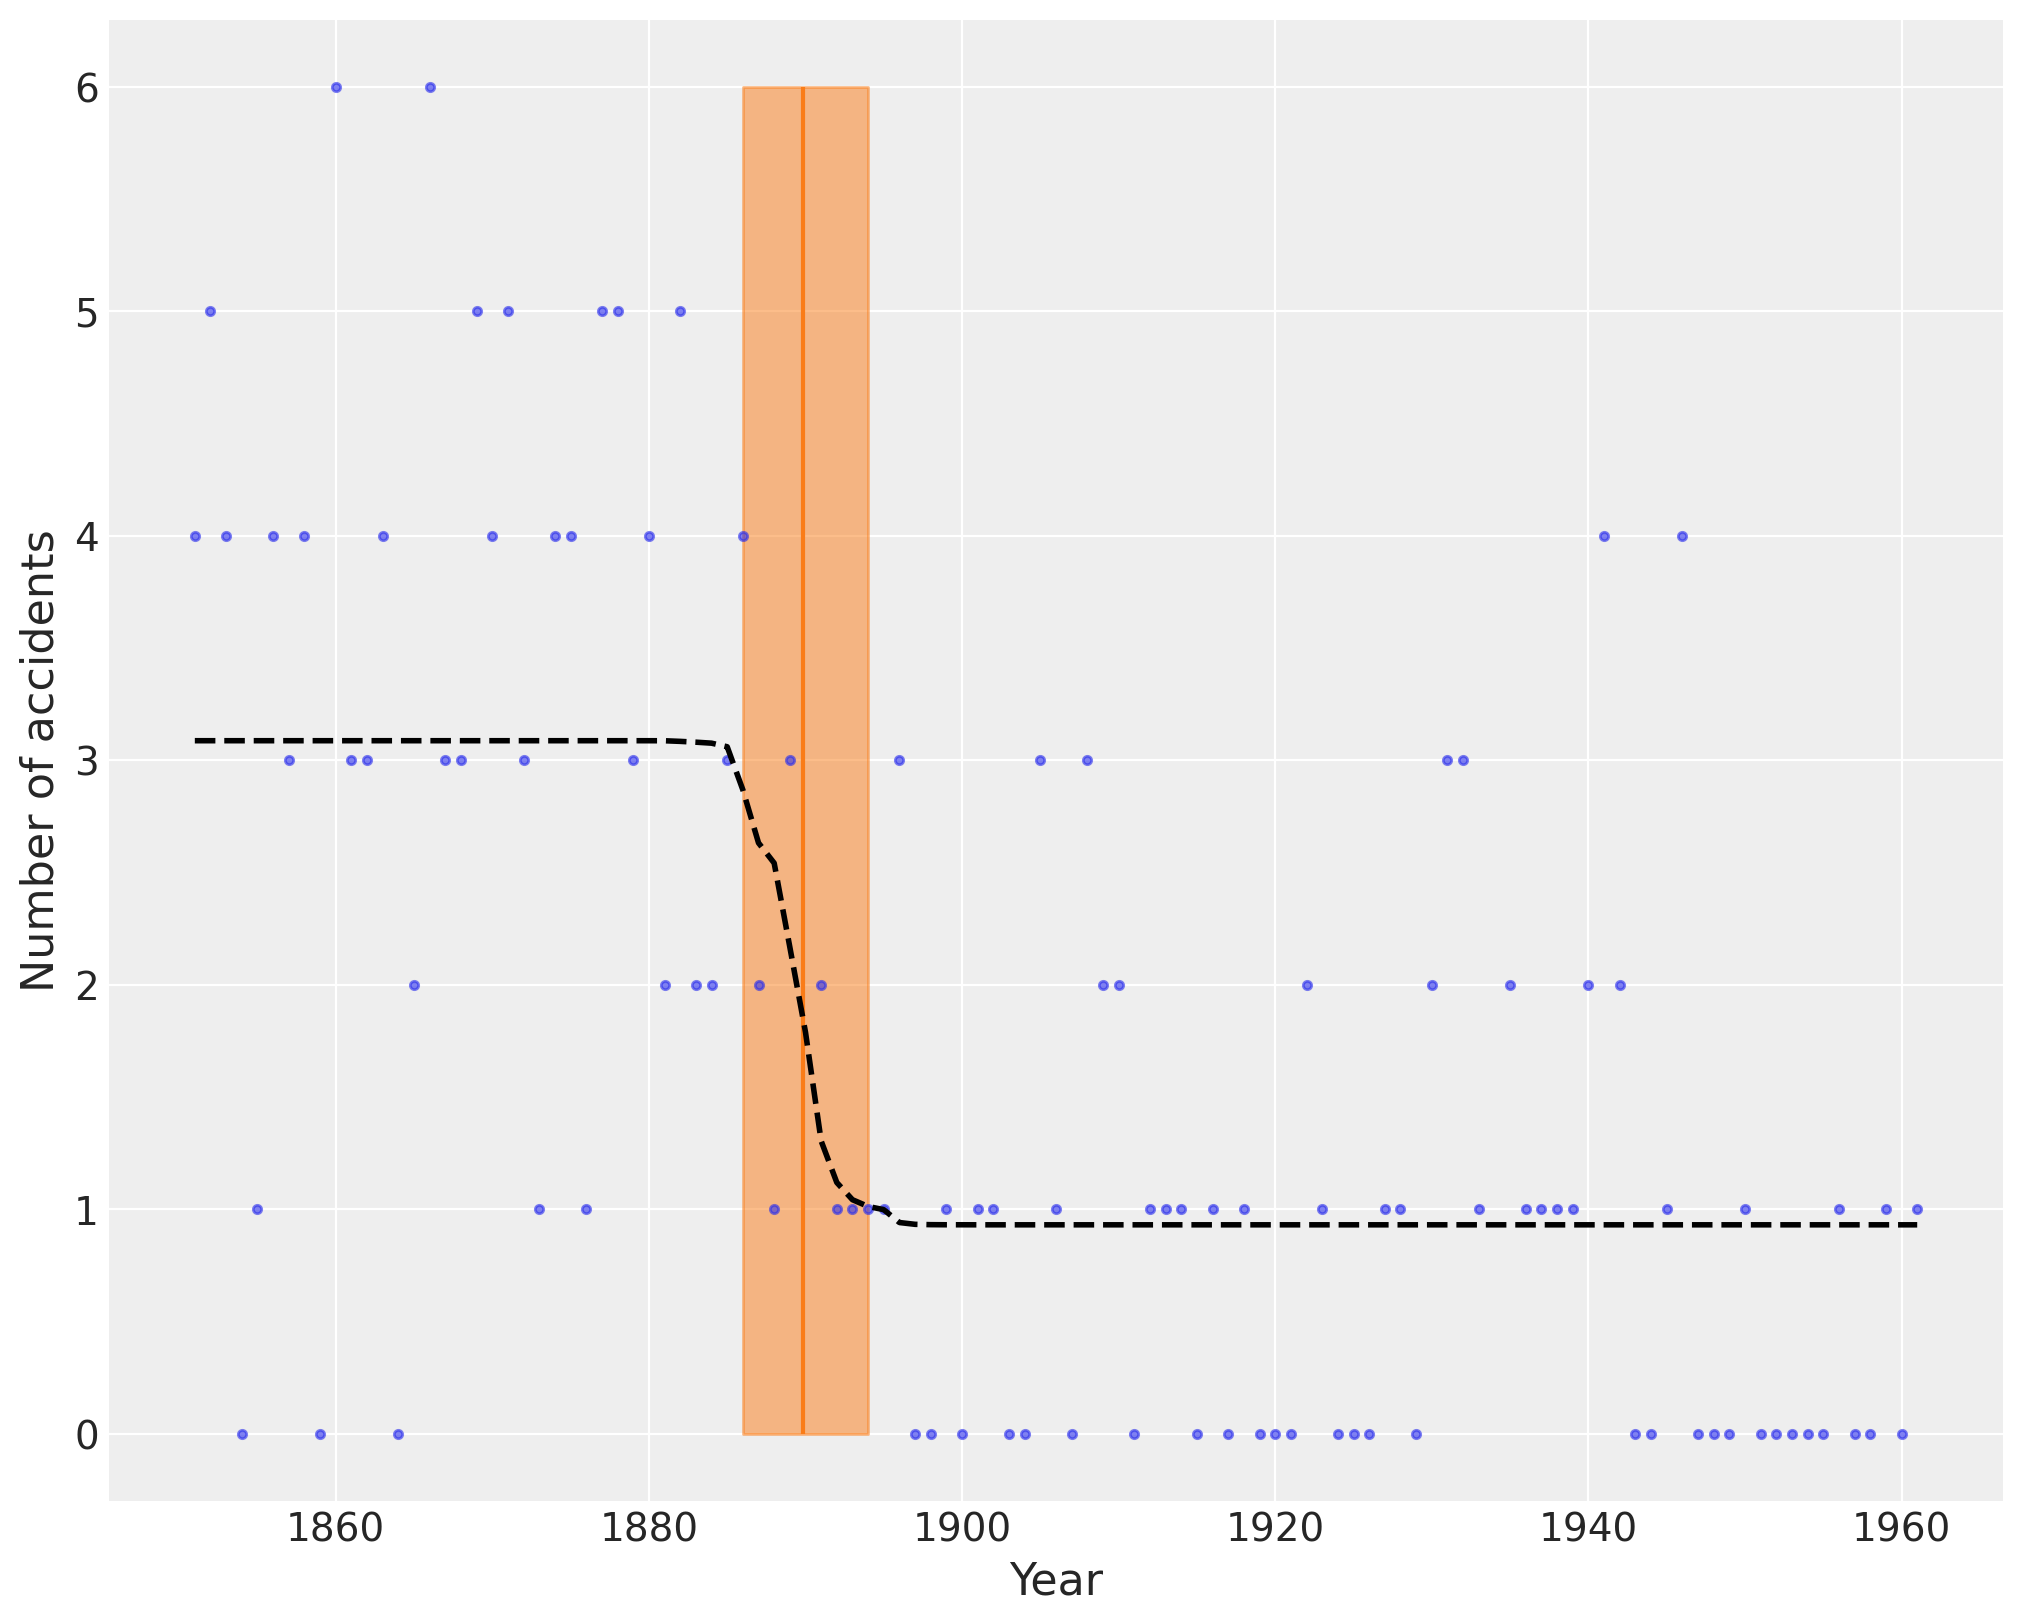

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    # e.g. `year` is 1890; first of trace["switchpoint"] is 1887
    # for the sample, the current year of interest is after switch-point
    # i.e. `year < trace["switchpoint"]` evaluates to false
    # so we are interested in the lambda (i.e. average number of accidents) after the switch-point
    # which corresponds to late_rate
    # so np.mean is taking the average of all the lambas for the corresponding year
    idx = year < trace["switchpoint"]
    # this basically gets either the early-rate or the late-rate for the observation depending
    # on if the corresponding switch-rate after/before the current year
    # i.e. if the year is 1890, and a given sample's switchpoint is 1891, then the late-rate isn't
    # applicable; we need the early-rate
    # i.e. get the applicable rate (i.e. lambda i.e. average incidents) for each observation and
    # then average all of the rates relative to the current year
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(idata, var_names=["switchpoint"])
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd["switchpoint"].values[0],
    x2=sp_hpd["switchpoint"].values[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);

**NOTE**: the `early_rate` and `late_rate` values correspond to the the lambda parameter of the poisson distribution, which by definition is simply the `the mean number of events within a given interval of time`. This is how we plot the average number of accidents per year (dotted black line).

In [47]:
df = pd.DataFrame(dict(
    switch_point=trace["switchpoint"].values,
    early_rate=trace["early_rate"].values,
    late_rate=trace["late_rate"].values,
))
df

switch_point  early_rate  late_rate
0              1887    3.038830   1.068352
1              1887    2.874493   0.920077
2              1887    3.344506   1.029139
3              1887    3.061937   0.963312
4              1887    3.380519   0.916700
...             ...         ...        ...
39995          1890    3.306411   1.006736
39996          1890    2.838121   0.968104
39997          1891    3.614445   0.842484
39998          1891    3.197337   0.905754
39999          1890    3.623623   1.008286

[40000 rows x 3 columns]

In [49]:
df.groupby('switch_point').mean()

early_rate  late_rate
switch_point                       
1880            3.545930   1.251431
1881            2.982584   1.322892
1882            3.331810   1.080528
1883            3.220425   1.064250
1884            3.194619   1.027290
1885            3.159347   1.020139
1886            3.194320   0.971605
1887            3.152832   0.956807
1888            3.100253   0.959853
1889            3.107883   0.930958
1890            3.095866   0.930078
1891            3.081709   0.913011
1892            3.023499   0.911942
1893            2.968129   0.913571
1894            2.921900   0.901407
1895            2.869198   0.913233
1896            2.885536   0.883861
1897            2.810427   0.887754
1898            2.754093   0.882720
1899            2.707661   0.888261
1901            2.736506   0.853743

In [52]:
def temp(year):
    index_filter = year < trace["switchpoint"]
    # print(index_filter.values.mean())
    # print(trace['early_rate'].values[filter_1890].mean())
    # print(trace['late_rate'].values[filter_1890].mean())
    return np.mean(np.where(index_filter, trace["early_rate"], trace["late_rate"]))

[(x, temp(x)) for x in np.linspace(1860, 1960, 50)]


[(1860.0, 3.0877913333326994),
 (1862.0408163265306, 3.0877913333326994),
 (1864.0816326530612, 3.0877913333326994),
 (1866.1224489795918, 3.0877913333326994),
 (1868.1632653061224, 3.0877913333326994),
 (1870.204081632653, 3.0877913333326994),
 (1872.2448979591836, 3.0877913333326994),
 (1874.2857142857142, 3.0877913333326994),
 (1876.3265306122448, 3.0877913333326994),
 (1878.3673469387754, 3.0877913333326994),
 (1880.408163265306, 3.087733970848717),
 (1882.4489795918366, 3.0848516726241066),
 (1884.4897959183672, 3.0768512378605513),
 (1886.530612244898, 2.86870692981711),
 (1888.5714285714287, 2.5426303939344495),
 (1890.6122448979593, 1.7891327681296818),
 (1892.6530612244899, 1.1195720363720225),
 (1894.6938775510205, 1.0128316744847812),
 (1896.734693877551, 0.941302946112573),
 (1898.7755102040817, 0.9317799724859885),
 (1900.8163265306123, 0.9313251225910817),
 (1902.857142857143, 0.9311368463186074),
 (1904.8979591836735, 0.9311368463186074),
 (1906.938775510204, 0.931136846

In [236]:
pre_1900 = np.extract(years < 1900, disaster_data)
print(pre_1900)
np.mean(pre_1900[~np.isnan(pre_1900)])

[ 4.  5.  4.  0.  1.  4.  3.  4.  0.  6.  3.  3.  4.  0.  2.  6.  3.  3.
  5.  4.  5.  3.  1.  4.  4.  1.  5.  5.  3.  4.  2.  5.  2.  2.  3.  4.
  2.  1.  3. nan  2.  1.  1.  1.  1.  3.  0.  0.  1.]


2.7708333333333335

In [237]:
post_1900 = np.extract(years >= 1900, disaster_data)
print(post_1900)
np.mean(post_1900[~np.isnan(post_1900)])

[ 0.  1.  1.  0.  0.  3.  1.  0.  3.  2.  2.  0.  1.  1.  1.  0.  1.  0.
  1.  0.  0.  0.  2.  1.  0.  0.  0.  1.  1.  0.  2.  3.  3.  1. nan  2.
  1.  1.  1.  1.  2.  4.  2.  0.  0.  1.  4.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  1.]


0.9016393442622951

In [213]:
sp_hpd

<xarray.Dataset>
Dimensions:      (hdi: 2)
Coordinates:
  * hdi          (hdi) <U6 'lower' 'higher'
Data variables:
    switchpoint  (hdi) float64 1.886e+03 1.894e+03

In [215]:
sp_hpd["switchpoint"]

<xarray.DataArray 'switchpoint' (hdi: 2)>
array([1886., 1894.])
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'

In [216]:
sp_hpd.to_pandas()

switchpoint
hdi                
lower        1886.0
higher       1894.0

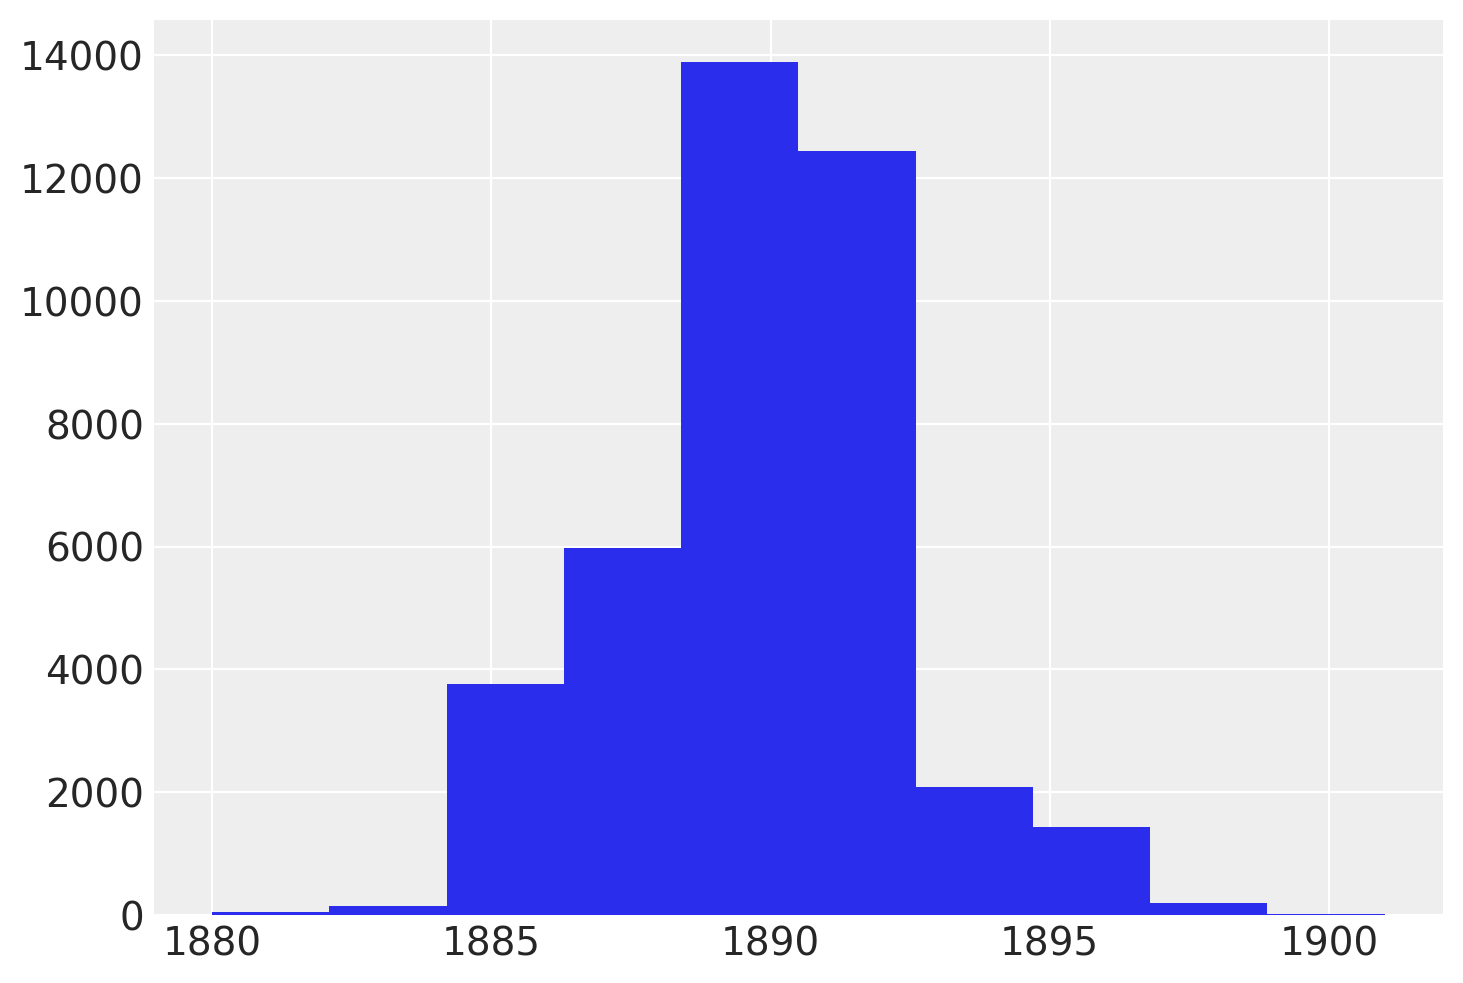

In [21]:
plt.hist(trace["switchpoint"].values);

In [55]:
trace["switchpoint"].values

array([1887, 1887, 1887, ..., 1891, 1891, 1890])

In [56]:
az.hdi(idata, var_names=["switchpoint"])

<xarray.Dataset>
Dimensions:      (hdi: 2)
Coordinates:
  * hdi          (hdi) <U6 'lower' 'higher'
Data variables:
    switchpoint  (hdi) float64 1.886e+03 1.894e+03

In [60]:
az.hdi(idata, var_names=["switchpoint"], hdi_prob=0.95).to_dataframe()

switchpoint
hdi                
lower        1885.0
higher       1894.0

In [61]:
az.hdi(idata, var_names=["switchpoint"], hdi_prob=0.66).to_dataframe()

switchpoint
hdi                
lower        1887.0
higher       1891.0

In [62]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

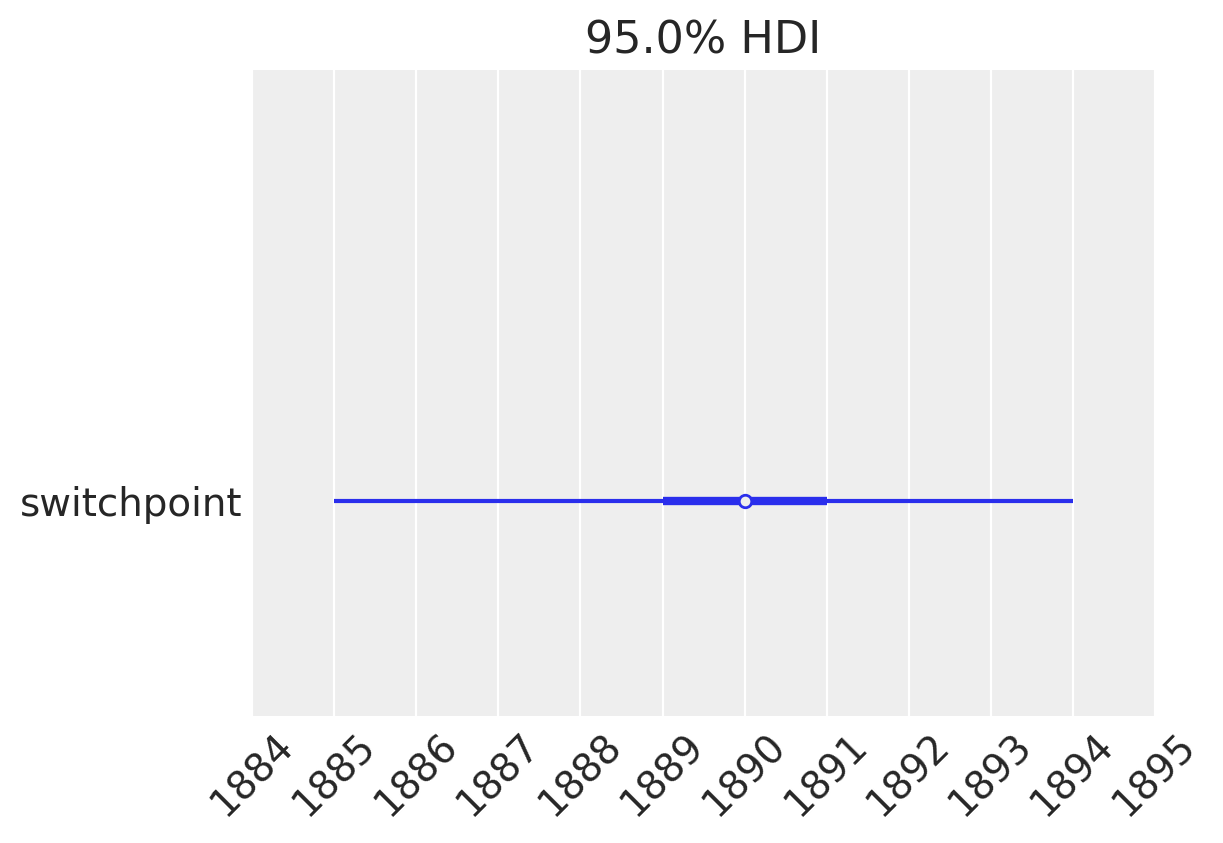

In [85]:
# inner_prob = 0.66
# inner_probs = (1 - inner_prob) / 2, 1 - (1 - inner_prob) / 2
# print(inner_probs)
az.plot_forest(
    idata,
    var_names=["switchpoint"],
    combined=True,
    hdi_prob=0.95,
    #quartiles=[inner_probs[0], .5, inner_probs[1]],
    quartiles=True,  # can't seem to set
    r_hat=False,
)
plt.xticks(np.arange(1884, 1896, 1.0), rotation=45);